# Word2Vec Skip-Gram Model

Adapted from: <br>
https://adoni.github.io/2017/11/08/word2vec-pytorch/ <br>
https://github.com/Adoni/word2vec_pytorch/blob/master/model.py <br>
https://github.com/fanglanting/skip-gram-pytorch/blob/master/model.py<br>
http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/<br>
http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/ <br>
https://github.com/udacity/deep-learning/blob/master/embeddings/Skip-Grams-Solution.ipynb <br>
https://towardsdatascience.com/implementing-word2vec-in-pytorch-skip-gram-model-e6bae040d2fb - (good intuition on what the softmax is doing)
https://gist.github.com/lirnli/c6e02efc414b4473abbb8152d303514c <br>
https://github.com/LianHaiMiao/pytorch-lesson-zh/blob/master/NLP/py/word2vec.py <br>
http://ruder.io/word-embeddings-softmax/ <br>
https://arxiv.org/pdf/1411.2738.pdf

Input a word and predict its context words inside a context window of words - computationally expensive !

**To solve**: <br>
    1 - Apply subsampling of frequent words ("the", "of", "and", etc.) <br>
    2 - Apply negative sampling (only a few words are chosen as negative context words) <br>

The key is in the numerator of the softmax function. <br>
It multiplies the incoming embedding vector for the word by the weight of the neuron (here the weight can be interpreted as the value for that particular context word). <br>
Incoming embedded vector - input/center word<br>
output weight - context word (positive or negative - if positive, numerator should be higher in order to decrease the Loss)

In [306]:
%matplotlib inline
import itertools
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from collections import deque
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import functional as F

from glob import glob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist

### Load text

In [56]:
path = './aclImdb/train/pos/*.txt'
corpus = ""

for filename in glob(path):
    with open(filename,'r') as f:
        corpus += "\n" + f.read()

#### Save compiled files to disk

In [57]:
#with open("./aclImdb/corpus.txt", "w+") as f:
#    f.write(corpus[:1000000])
#    f.close()

In [4]:
corpus = word_tokenize(corpus[:50000])
# stop_words = set(stopwords.words('english'))
# corpus = [w for w in corpus if w not in stop_words]

## Corpus sample

In [6]:
print('length of texts: ', len(corpus))
print('number of unique words:', len(set(corpus)))
print('a sample below')
corpus[:20]

length of texts:  10625
number of unique words: 2881
a sample below


['For',
 'a',
 'movie',
 'that',
 'gets',
 'no',
 'respect',
 'there',
 'sure',
 'are',
 'a',
 'lot',
 'of',
 'memorable',
 'quotes',
 'listed',
 'for',
 'this',
 'gem',
 '.']

### 20 most frequent words (tokens)

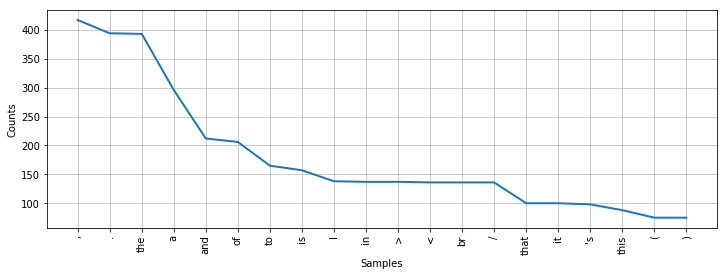

In [7]:
dist = FreqDist(corpus)
dist.most_common(20)
plt.figure(figsize=[12,4])
dist.plot(20)

In [8]:
words_occurred_only_once = [w for w in dist.most_common() if w[1]==1]
print('number of words occurred only once', len(words_occurred_only_once))

number of words occurred only once 1976


### Frequency with respects to word count

In the plot below, most words in the vocabulary occurrs less than 5 times.

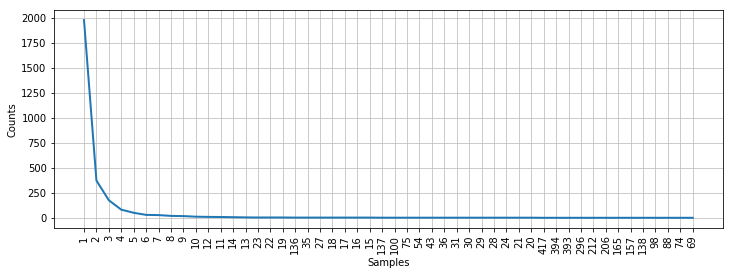

In [9]:
occurr_dist = FreqDist([w[1] for w in dist.most_common()])
plt.figure(figsize=[12,4])
occurr_dist.plot(50)

In [10]:
percent = sum([w[1] for w in occurr_dist.most_common() if w[1]<=5])/sum([w[1] for w in occurr_dist.most_common()])
print('words occurred <= 5 times in corpus:',percent)

words occurred <= 5 times in corpus: 0.030892051371051717


### Negative Sampling

The “negative samples” (that is, the c output words that we’ll train to output 0) are chosen using a “unigram distribution”.

Essentially, the probability for selecting a word as a negative sample is related to its frequency, with more frequent words being more likely to be selected as negative samples.

In the word2vec C implementation, you can see the equation for this probability. Each word is given a weight equal to it’s frequency (word count) raised to the 3/4 power. The probability for a selecting a word is just it’s weight divided by the sum of weights for all words:

$$P(w_i) = \frac{  {f(w_i)}^{3/4}  }{\sum_{j=0}^{n}\left(  {f(w_j)}^{3/4} \right) }$$

Source: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/

In [73]:
# Word frequency
word_frequency = dict(FreqDist(corpus))

In [74]:
# Word - ID mapping
word2id = {}
with open("./aclImdb/corpus.txt", 'r', newline="\n") as f:      
    for line in f: 
        tokens = word_tokenize(line)
        
        if word2id:
            word2id.update({word:0 for word in tokens})
        else:
            word2id = {word:0 for word in tokens}

for i, (word, value) in enumerate(list(word2id.items())):
    word2id[word] = i    

In [75]:
id2word = {i: word for word, i in word2id.items()}
#word_count = len(word2id)

In [76]:
# Probability for a given word i in the corpus
pow_frequency = np.array(list(word_frequency.values()))**0.75
words_pow = sum(pow_frequency) 
p_wi = pow_frequency / words_pow

Tis is the way Word2Vec C code implemented choosing negative samples. <br>
They have a large array with 100M elements (which they refer to as the unigram table). They fill this table with the index of each word in the vocabulary multiple times - the number of times a word’s index appears in the table is given by **P(wi) * table_size**. <br>
Then, to actually select a negative sample, you just generate a random integer between 0 and 100M, and use the word at that index in the table. <br>
Since the higher probability words occur more times in the table, you’re more likely to pick those.

Source: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/

In [77]:
sample_table = []
sample_table_size = 1e8 # empty 100 million array

# Generate "unigram" table
count = np.round(p_wi * sample_table_size) # number of times a word’s index will appear in the table

# Fill the table 
for wid, c in enumerate(count):
    sample_table += [wid] * int(c)
    
sample_table = np.array(sample_table)

#### Function to generate samples

This will generate 3 matrices: batch x 1 <br><br>
**center_words** - list of center (input) word IDs <br>
**positive_words** - list of positive context (neighbour) word IDs <br>
**negative_words** - list of negative words IDs (not in the specified window size)

In [152]:
def generate_samples(window_size, word_dict, sample_table, n_samples, random_seed=777):

    word_pair_catch = deque()
    word_ids = []
    center_words = []
    positive_words = []
    
    np.random.seed(random_seed)
    
    with open("./aclImdb/corpus.txt", 'r', newline="\n") as f:      
        for sentence in itertools.islice(f, None, n_samples):
            word_ids = []
            for word in word_tokenize(sentence):
                word_ids.append(word_dict[word])

            for i, u in enumerate(word_ids):
                for j, v in enumerate(
                        word_ids[max(i - window_size + 1, 0):i + window_size + 1]):            
                    if i == j:
                        continue
                    word_pair_catch.append((u, v))

            for _ in range(len(word_pair_catch)):
                _pair = word_pair_catch.popleft()

                center_words.append(_pair[0])
                positive_words.append(_pair[1])

    neg_words = np.random.choice(
    sample_table, size=((len(center_words)), window_size)).tolist()
    center_words = torch.LongTensor([center_words]).t()
    positive_words = torch.LongTensor([positive_words]).t()
    negative_words = torch.LongTensor(neg_words)
    
    return center_words, positive_words, negative_words

The **Negative Sampling Loss** to be used is given by:

$$ \frac{1}{T}  \sum_{t=1}^T  \: \sum_{-c<=j<c, j\neq0} \:\text{log} \: p( {w_{t+j}|w_{t}} ) $$ 

$$ Where: \text{log} \: p( {w_{t+j}|w_{t}} ) = J_\theta $$ 

$$J_\theta = - \sum_{w_i \in V} [ \text{log} \: \sigma(h \times v_{w_O}^\top ) - \: \sum_{j=1}^k \:\text{log} \: \sigma(h \times -v_{w_j}^\top)]$$ 

Sources: <br>
https://arxiv.org/pdf/1411.2738.pdf <br>
https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf

Where: $$w_1, w_2, w_3, \cdots, w_T$$ Are a sequence of T training words that belong to a vocabulary V. <br> 
$$h$$ Is the input word embedding indexed from the embedding matrix with d dimensions. <br>
$$v_{w_O}$$ Is the output vector (embedding vector) for the output word (positive context target word) 
$$v_{w_j}$$ Is the output vector (embedding vector) for the output word (from j=1 to k negative context words) 

The formula is adapted for the matrix shapes used in this notebook (x denotes batch matrix multiplication)

#### Set hyperparameters and helper lists

In [257]:
random_seed = 777
batch_size = 128
emb_dimension = 10
window_size = 5
n_epochs = 40
learning_rate = 0.001
vocab_size = len(word2id)

#### Get samples for training

#### Inspect center and positive samples

In [141]:
print(center_words[:5])
print([id2word[j[0]] for j in list(center_words[:5].numpy())])
print()
print(positive_words[:5])
print([id2word[j[0]] for j in list(positive_words[:5].numpy())])

tensor([[ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0]])
['For', 'For', 'For', 'For', 'For']

tensor([[ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5]])
['a', 'movie', 'that', 'gets', 'no']


#### Inspect negative samples

In [137]:
print(negative_words[:5])
print([id2word[j] for j in list(negative_words[0].numpy())])

tensor([[ 44,  38,  12,   9,  56],
        [ 61,   1,  35,  19,   7],
        [  5,  21,   7,  24,  12],
        [ 22,   3,  11,  18,  31],
        [ 10,   2,  27,   2,  20]])
['as', 'Alan', 'memorable', 'are', 'Cristina']


#### Create Batch Loader

In [293]:
center_words, positive_words, negative_words = generate_samples(window_size, word2id, 
                                                                sample_table, 500, random_seed)
imdb_dataset = TensorDataset(center_words, positive_words, negative_words)
imdb_loader = DataLoader(imdb_dataset, 
                         batch_size=batch_size, 
                         shuffle=True,
                         num_workers=32, 
                         drop_last=True)

#### Define model

In [294]:
class SkipGram_NegSamp_Model(nn.Module):
    def __init__(self, vocab_size, emb_dimension, random_seed):
        super(SkipGram_NegSamp_Model, self).__init__()
        self.random_seed = random_seed
        self.emb_dimension = emb_dimension
        self.center_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        self.context_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        self.init_emb()
        
    def init_emb(self):
        """Initialize embedding weights like word2vec.
        The u_embedding is a uniform distribution in [-0.5/em_size, 0.5/emb_size], 
        and the elements of v_embedding are zeros.
        """        
        torch.manual_seed(self.random_seed)
        initrange = 0.5 / self.emb_dimension
        self.center_embeddings.weight.data.uniform_(-initrange, initrange)
        self.context_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, center_words, positive_words, negative_words):       

        center_embeds = self.center_embeddings(center_words)      # Batch x 1 x Emb Dim
        positive_embeds = self.context_embeddings(positive_words) # Batch x 1 x Emb Dim
        neg_embeds = self.context_embeddings(negative_words)      # Batch x window_size x Emb Dim                                   

        positive_score = torch.bmm(center_embeds, 
                                   positive_embeds.transpose(1,2)).squeeze(-1) # Batch x 1
        
        #positive_score = torch.mul(center_embeds, positive_embeds).squeeze()
        #positive_score = torch.sum(positive_score, dim=1) # this approach is way faster but needs more code
        
        positive_score = F.logsigmoid(positive_score)

        negative_score = -1 * torch.bmm(center_embeds, 
                                        neg_embeds.transpose(1,2)).squeeze(1) # Batch x window_size
        negative_score = F.logsigmoid(negative_score)
        negative_score = torch.sum(negative_score, 1).unsqueeze(1)

        return torch.sum(-positive_score - negative_score)

#### Instantiate model and optimizer

In [295]:
model = SkipGram_NegSamp_Model(vocab_size, emb_dimension, random_seed)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=learning_rate)

#### Train the model

epoch 0, epoch_loss 163.40265608294183
epoch 1, epoch_loss 99.94420219672668
epoch 2, epoch_loss 90.14164253818296
epoch 3, epoch_loss 85.44861745247668
epoch 4, epoch_loss 82.56630042338041
epoch 5, epoch_loss 80.64594452168575
epoch 6, epoch_loss 79.28761194818696
epoch 7, epoch_loss 78.27678886787606
epoch 8, epoch_loss 77.48799783777788
epoch 9, epoch_loss 76.84055519970488
epoch 10, epoch_loss 76.28149262788777
epoch 11, epoch_loss 75.79340425152321
epoch 12, epoch_loss 75.35881707182261
epoch 13, epoch_loss 74.95294996366658
epoch 14, epoch_loss 74.58178074793587
epoch 15, epoch_loss 74.24199108460986
epoch 16, epoch_loss 73.92468013759817
epoch 17, epoch_loss 73.62761636676605
epoch 18, epoch_loss 73.35206158197718
epoch 19, epoch_loss 73.09238376722132
epoch 20, epoch_loss 72.8497102893755
epoch 21, epoch_loss 72.62019002886629
epoch 22, epoch_loss 72.40782357128691
epoch 23, epoch_loss 72.20963480435107
epoch 24, epoch_loss 72.01537494092598
epoch 25, epoch_loss 71.83989563616

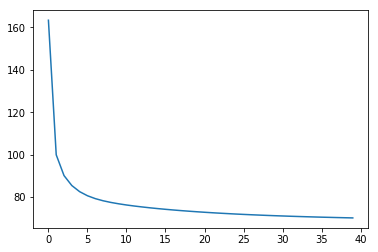

In [296]:
plot_train = []
save_loss = []

for epoch in range(n_epochs):
    epoch_loss = []
    for batch_idx, (center_words, positive_words, negative_words) in enumerate(imdb_loader):
        
        # forward, backward, optimize
        optimizer.zero_grad()        
        loss = model.forward(center_words, positive_words, negative_words)
        loss.backward()
        optimizer.step()                          
        
        # save loss
        epoch_loss.append(loss.item())
        
    epoch_loss = np.mean(epoch_loss)
    save_loss.append(epoch_loss)
    if epoch%1 == 0:
        print('epoch {}, epoch_loss {}'.format(epoch, epoch_loss))

pd.Series(save_loss).plot()              

### Evaluate Embeddings quality

In [297]:
def get_encoding(word, word_dict, embedding):
    return embedding[word2id[word]]

In [298]:
def word_similarity(word1, word2):
    params = {"word_dict":word2id, 
              "embedding":model.center_embeddings.weight.data.numpy()}
    v1 = get_encoding(word1, **params)
    v2 = get_encoding(word2, **params)
    res = 1 - cosine(v1,v2)
    return res

In [299]:
def word_scatter(xs, labels,fontsize=14):
    for i, t in enumerate(labels):
        plt.annotate(t,xs[i],fontsize=fontsize)

In [300]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

#### Word similarity

Text(0.5,1,'PCA transformation of word vector')

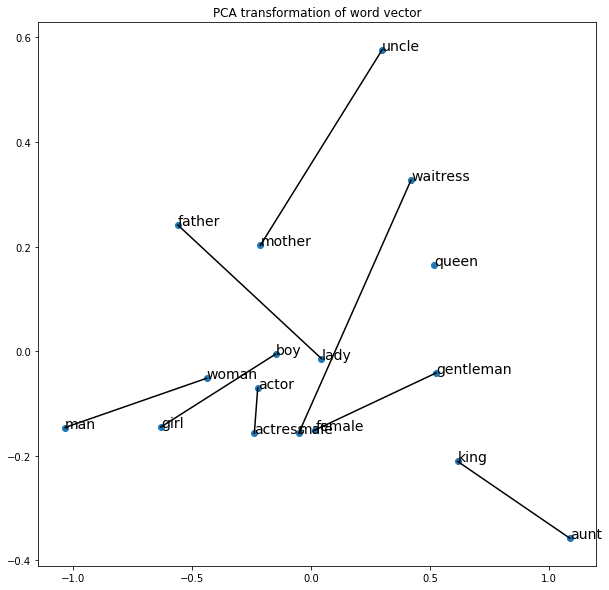

In [301]:
plt.figure(figsize=[10,10])
labels = 'man woman boy girl actor actress waitress male female gentleman lady father mother uncle aunt king queen'.split()

coords = [word2id[w] for w in labels]
coords = (model.center_embeddings.weight).data.numpy()[coords,:]

y_scatter = pca.fit_transform(coords)
plt.scatter(y_scatter[:,0], y_scatter[:,1])
word_scatter(y_scatter, labels)

for i in range(0,y_scatter.shape[0],2):
    plt.plot(y_scatter[i:i+2,0],y_scatter[i:i+2,1],'black')
plt.title('PCA transformation of word vector')

In [302]:
print('nice','good', word_similarity('nice','good'))
print('dog','cat', word_similarity('dog','cat'))
print('dog','animal', word_similarity('dog','animal'))
print('cat','animal', word_similarity('cat','animal'))
print('good','fantastic', word_similarity('good','fantastic'))
print('good','terrible', word_similarity('good','terrible'))
print('mother','father', word_similarity('mother','father'))
print('king','queen', word_similarity('king','queen'))
print('boy','girl', word_similarity('boy','girl'))
print('hate','love', word_similarity('hate','love'))
print('ugly','beautiful', word_similarity('ugly','beautiful'))
print('angry','happy', word_similarity('angry','happy'))
print('do','did', word_similarity('do','did'))
print('do','does', word_similarity('do','does'))
print('do','done', word_similarity('do','done'))

nice good 0.9818171262741089
dog cat 0.8637010455131531
dog animal 0.9087255001068115
cat animal 0.8488715887069702
good fantastic 0.9599630832672119
good terrible 0.8602429032325745
mother father 0.9875409603118896
king queen 0.8891010880470276
boy girl 0.9357727766036987
hate love 0.8908922672271729
ugly beautiful 0.6843808889389038
angry happy 0.8510186672210693
do did 0.999099850654602
do does 0.9974617958068848
do done 0.9628074169158936


#### Test alternative implementation

### Check this for embedding averaging of context words

In [15]:
class SkipGramWordVectorNet(nn.Module):
    def __init__(self, n_embedding, embedding_freq, negative_sampling_size=10, embedding_dim=5):
        #n_embedding: vocabulary size
        #embedding_freq: used for negative sampling
        #negative_sampling_size: how many negative samples to be used
        #embedding_dim: dimension of word vectors
        
        super(SkipGramWordVectorNet,self).__init__()
        self.n_embedding = n_embedding
        self.embedding_freq = Variable(torch.Tensor(embedding_freq)**(0.75))
        self.negative_sampling_size = negative_sampling_size
        self.word_embedding = nn.Embedding(n_embedding,embedding_dim)
        self.context_embedding = nn.Embedding(n_embedding,embedding_dim)
        
    def forward(self, input):
        #return embedding
        
        return self.word_embedding(input) + self.context_embedding(input)
    
    def calculate_loss(self, word, context,alpha=0.1):
        #word.size() batch_size
        #context.size() batch_size*window_size
        
        word_pos = word.view(-1,1).expand_as(context)
        word_pos = self.word_embedding(word_pos)
        context = self.context_embedding(context)
        product_pos = (word_pos*context).sum(dim=-1).mean()
        target_pos = Variable(torch.ones(product_pos.size()))
        loss_positive = nn.functional.binary_cross_entropy_with_logits(product_pos,target_pos)
        
        #negative sampling
        negative_context = self.embedding_freq.multinomial(
            self.negative_sampling_size*context.size(0)*context.size(1), replacement=True)        
        negative_context = negative_context.view(-1,self.negative_sampling_size*context.size(1))
        
        word_neg = word.view(-1,1).expand_as(negative_context)
        word_neg = self.word_embedding(word_neg)
        negative_context = self.context_embedding(negative_context)
        
        product_neg = (word_neg*negative_context).sum(dim=-1).mean()
        target_neg = Variable(torch.zeros(product_neg.size()))
        
        loss_negative = nn.functional.binary_cross_entropy_with_logits(product_neg,target_neg)
        
#         # l2 regularization
#         loss_l2 = sum([(w**2).sum(dim=-1).mean() 
#                        for w in (word_pos,context,word_neg,negative_context)])
#         loss_l2 = loss_l2*alpha
#         loss = loss_positive + loss_negative + loss_l2
        loss = loss_positive + loss_negative
        return loss

### Batch generator

In [17]:
def batch_generator(batch_size=100,window_size=5):
    torch.manual_seed(7777)
    np.random.seed(777)
    n_corpus = len(corpus)
    int_corpus = np.array([word_2_int[word] for word in corpus])
    batches = np.random.permutation(range(window_size,n_corpus-window_size))
    batches = torch.from_numpy(batches).split(batch_size)
    
    for word in batches:
        torch.manual_seed(7777)
        np.random.seed(777)
        word = np.reshape(word.numpy(),[-1,1])
        context = np.concatenate([word-i for i in range(-window_size, window_size+1) if i != 0],axis=1)
        word = int_corpus[word]
        context = int_corpus[context]
        word = Variable(torch.from_numpy(word))
        context = Variable(torch.from_numpy(context))
        yield word, context